# Accentual Responsion in Pindar

*100 shuffled Aristophanic antistrophic tetrameter null:* **0.810**

In [1]:
from collections import Counter

from src.stats_comp import compatibility_corpus, compatibility_ratios_to_stats

all_sets = compatibility_corpus('data/compiled/')
total_comp = compatibility_ratios_to_stats(all_sets)

print(f'Total compatibility: {total_comp}')
print(all_sets)

found_zero = False
number_of_variables = 0
value_distribution = {
    '0': 0,
    '1/4': 0,
    '1/3:': 0,
    '1/2': 0,
    '2/3': 0,
    '3/4': 0,
    '1': 0,
}

values = []
for element in all_sets:
    for subelement in element:
        for subsubelement in subelement:
            for value in subsubelement:
                number_of_variables += 1
                values.append(value)
                if value == 0.0:
                    found_zero = True
                
if found_zero:
    print("Found zero")
print(f'Number of variables: {number_of_variables}')

count_dict = Counter(values)
print(count_dict)

def round_nested(d, ndigits=3):
    """
    Recursively rounds all floats in a nested dict/list structure.
    """
    if isinstance(d, dict):
        return {k: round_nested(v, ndigits) for k, v in d.items()}
    elif isinstance(d, list):
        return [round_nested(v, ndigits) for v in d]
    elif isinstance(d, float):
        return round(d, ndigits)
    else:
        return d

print(round_nested(all_sets))

Total compatibility: 0.6919157608695652
[[[[0.625, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.75, 0.625, 1.0, 1.0], [0.875, 0.5, 0.625, 0.875, 0.5, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.5, 0.75, 0.75, 0.75, 0.875, 0.75, 0.625, 0.625, 0.625, 0.625, 1.0, 1.0], [0.625, 0.5, 0.5, 0.5, 0.75, 0.75, 1.0, 0.625, 0.875, 0.625, 0.5, 0.75, 0.5, 0.875, 0.875, 0.5, 0.625, 0.875, 0.875, 1.0], [0.625, 0.625, 0.625, 0.625, 0.75, 0.5, 0.75, 0.875, 0.5, 0.5, 0.875, 0.625, 0.625, 0.5, 1.0], [0.875, 0.5, 0.625, 0.5, 0.5, 0.625, 0.625, 0.75, 0.75, 0.625, 0.5, 0.75, 0.625, 0.625, 1.0], [0.5, 1.0, 0.75, 0.75, 0.625, 0.625, 0.875, 0.625, 0.75, 0.625, 0.625, 0.5, 0.5, 0.875, 0.5, 0.625, 0.875, 1.0], [0.625, 0.5, 0.625, 0.625, 0.875, 0.875, 0.75, 0.75, 0.625, 0.875, 0.875, 0.75, 1.0, 1.0], [0.5, 0.875, 0.75, 0.5, 0.75, 0.625, 0.75, 0.625], [0.625, 0.625, 0.625, 0.875, 0.75, 0.5, 0.75, 0.75, 0.875, 1.0, 1.0], [0.625, 0.625, 0.75, 0.875, 0.75, 0.625, 0.625, 0.625, 0.5, 0.75, 0.625, 0.75, 0.625, 0.625, 0.625, 0.5, 0.

### Heatmap

In [3]:
from lxml import etree

# Load XML
tree = etree.parse("data/compiled/fourth_pythian_8.xml")
root = tree.getroot()

# Get first <strophe>
first_strophe = root.find(".//strophe[1]")

text_matrix = []

# Iterate over <l> children
for l in first_strophe.findall("l"):
    line_sylls = []
    buffer = ""
    prev_resolved = False
    
    for syll in l.findall("syll"):
        resolved = syll.get("resolution") == "True"
        content = syll.text or ""
        
        if prev_resolved and resolved:
            # join with previous
            buffer += content
        else:
            # flush previous buffer if any
            if buffer:
                line_sylls.append(buffer)
            buffer = content
        
        prev_resolved = resolved
    
    # Append any remaining buffer
    if buffer:
        line_sylls.append(buffer)
    
    text_matrix.append(line_sylls)

# Print the shape
num_rows = len(text_matrix)
row_lengths = [len(row) for row in text_matrix]
print(f"Number of rows: {num_rows}")
print(f"Length of each row: {row_lengths}")

Number of rows: 23
Length of each row: [11, 23, 20, 15, 15, 18, 14, 8, 11, 23, 20, 15, 15, 18, 14, 8, 19, 19, 15, 20, 16, 12, 19]


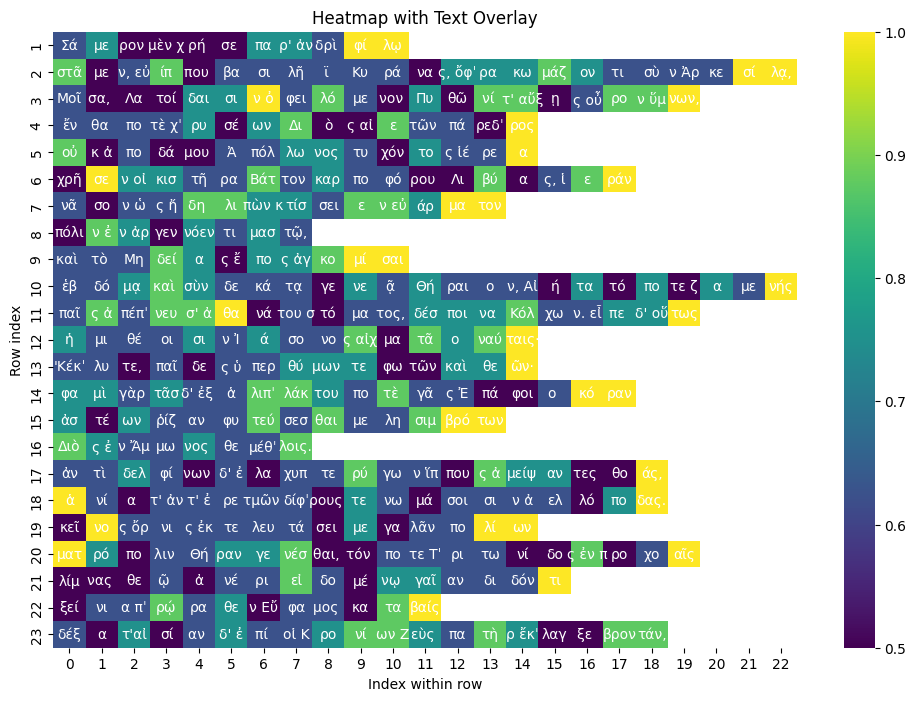

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

data = all_sets

# Unwrap nested tensor structure (since just one song, redundant cantica and play dims)
data_matrix = data[0][0]

# -----------------------------
# 3. Shape check
# -----------------------------
num_rows_text = len(text_matrix)
num_rows_data = len(data_matrix)

if num_rows_text != num_rows_data:
    raise ValueError(f"Number of rows mismatch: text_matrix={num_rows_text}, data_matrix={num_rows_data}")

max_len_text = max(len(row) for row in text_matrix)
max_len_data = max(len(row) for row in data_matrix)

if max_len_text != max_len_data:
    raise ValueError(f"Row length mismatch: max text length={max_len_text}, max data length={max_len_data}")

# -----------------------------
# 4. Pad numeric matrix for heatmap
# -----------------------------
max_len = max_len_data
padded_data = np.full((len(data_matrix), max_len), np.nan)
for i, row in enumerate(data_matrix):
    padded_data[i, :len(row)] = row

# -----------------------------
# 5. Plot heatmap with text overlay
# -----------------------------
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    padded_data, 
    cmap="viridis", 
    mask=np.isnan(padded_data), 
    cbar=True
)

# Overlay text
for i, row in enumerate(text_matrix):
    for j, val in enumerate(row):
        ax.text(
            j + 0.5, i + 0.5,  # center in cell
            val,
            ha='center', va='center',
            color='white', fontsize=10
        )

plt.xlabel("Index within row")
plt.ylabel("Row index")
plt.title("Heatmap with Text Overlay")
plt.yticks(ticks=np.arange(len(data_matrix)) + 0.5, labels=np.arange(1, len(data_matrix)+1))
plt.show()

# Barys

Tetrameter 3-strophes barys **baseline**: 0.15

Första 3 strofer i Pythia 4, barys: 0.25

Första 4, barys: 0.092

In [1]:
from src.stats_barys import barys_oxys_metric_corpus

corpus_dict = barys_oxys_metric_corpus('data/compiled', exclude_substr='baseline')

for key, value in corpus_dict.items():
    print(f'\t{key}: {value}')

Total barys match groups in corpus: 4
	barys_metric: 0.046065259117082535
	oxys_metric: 0.0
	barys_oxys_metric: 0.034139402560455195


In [1]:
from lxml import etree

from src.stats_barys import barys_accentually_responding_syllables_of_strophes_polystrophic, barys_detailed_print, count_all_barys_oxys_canticum

from src.utils.utils import polystrophic_cantica

barys_detailed_print("data/compiled/fourth_pythian_6.xml")


Canticum: py04
{'barys': 521, 'oxys': 182}
Barys match groups: 4
Barys metric: 0.046
Oxys metric:  0.000
Barys + Oxys metric: 0.034

--- BARYS MATCHES ---
  Match #1:
    (line 3, ord=13) => "θῶ"
    (line 26, ord=13) => "νώτω"
    (line 49, ord=13) => "γείου "
    (line 72, ord=13) => "χείρεσ"
    (line 95, ord=13) => "τάναι"
    (line 118, ord=13) => "είνα_"

  Match #2:
    (line 4, ord=12) => "τῶν "
    (line 27, ord=12) => "σπάσσαν"
    (line 50, ord=12) => "ρήσει "
    (line 73, ord=12) => "μάντευ"
    (line 96, ord=12) => "λέπτων "
    (line 119, ord=12) => "λῄσκων "

  Match #3:
    (line 6, ord=15) => "βύα"
    (line 29, ord=15) => "λίων "
    (line 52, ord=15) => "φέων "
    (line 75, ord=15) => "θέμεν "
    (line 98, ord=15) => "νέων "
    (line 121, ord=15) => "λέων "

  Match #4:
    (line 7, ord=9) => "τίσσει"
    (line 30, ord=9) => "θόντεσ"
    (line 53, ord=9) => "ρύσῳ "
    (line 76, ord=9) => "μῶ"
    (line 99, ord=9) => "θίστοι"
    (line 122, ord=9) => "γά_θη"

